In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from normalizer import Normalizer
from results import ModelEvaluation

In [8]:

data = pd.read_csv("../FinalModels/datasets/TwitterNews.csv")
texts= data["text"]
labels = data["label"]
results = ModelEvaluation()


In [9]:
tokenizer = Tokenizer(num_words=10000)  # Adjust num_words to fit your vocab size
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Define a max sequence length (or use the length of the longest sequence)
max_seq_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_seq_length, padding='post')


In [10]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_seq_length))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 41, 128)           1280000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable params: 1378945 (5.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.10)  # Adjust epochs, batch_size, and validation_split as needed


Epoch 1/2
900/900 [==============================] - 36s 29ms/step - loss: 0.5152 - accuracy: 0.7378 - val_loss: 0.4518 - val_accuracy: 0.7841
Epoch 2/2
900/900 [==============================] - 25s 28ms/step - loss: 0.3454 - accuracy: 0.8488 - val_loss: 0.4471 - val_accuracy: 0.7981


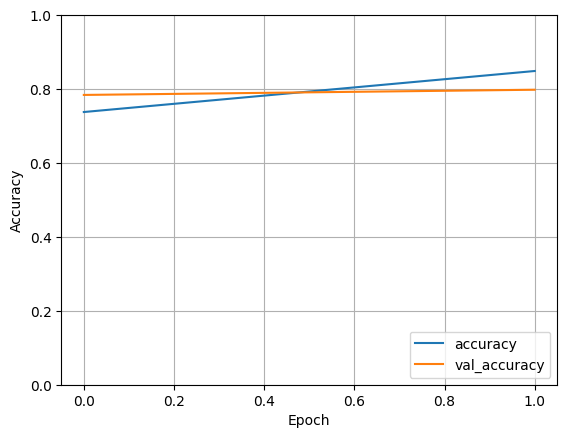

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()

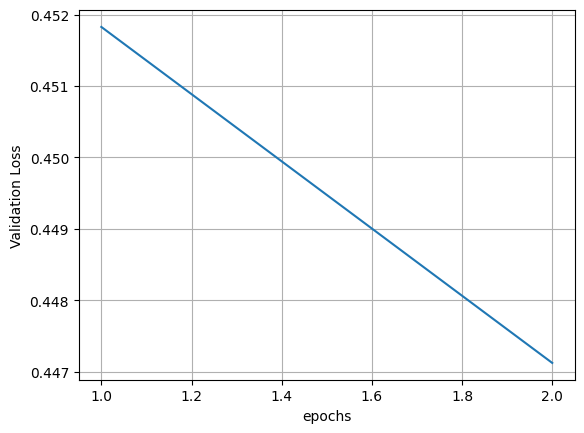

In [13]:
losses = history.history["val_loss"]
plt.plot(range(1,3), losses)
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.show()


In [14]:
y_pred = model.predict(X_test)

y_pred_class = (y_pred >= 0.5).astype(int)
results.classification_report(y_test, y_pred_class)


250/250 [==============================] - 3s 7ms/step
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      4000
           1       0.79      0.78      0.78      4000

    accuracy                           0.79      8000
   macro avg       0.79      0.79      0.79      8000
weighted avg       0.79      0.79      0.79      8000



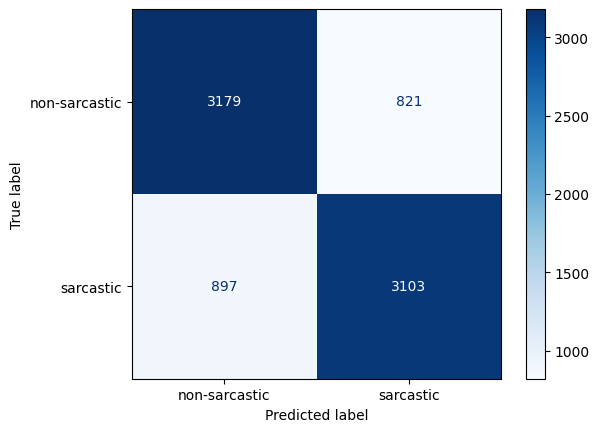

In [15]:
results.get_cm(y_true=y_test, y_pred=y_pred_class)

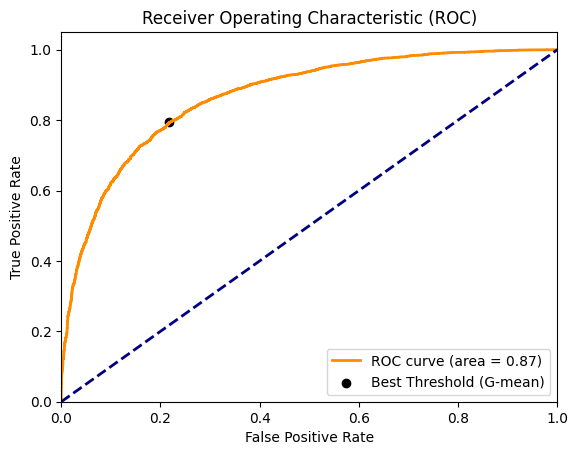

Best Threshold=0.4713


In [16]:
threshold = results.get_roc(y_test, y_pred)